### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors 
import matplotlib.cm
from numpy import linalg as LA
from ipywidgets import *
from manim import *

### Crossection color map animation


In [21]:
%%manim -ql -v WARNING --disable_caching ColorMapCrossSection
#creates animation of crosssections fadind into each other


class ColorMapCrossSection(Scene):
    def construct(self):
        
        #data array goes in here shape= (x,y,z) where z is the time axis
        # Generate 3D array data with random integers between 1 and 5
        x_size, y_size, z_size = 300, 300, 50
        data = np.random.randint(1, 3, (x_size, y_size, z_size))
        
        #creates the images (can be done outside of scene if correct naming is used)
        # Function to generate a color map from 2D data and save it as an image
        def create_colormap_image(data_slice, z_index):
            plt.imshow(data_slice, cmap='viridis', vmin=1, vmax=5)
            plt.axis('off')  # Remove axis
            # Save the plot as an image
            plt.savefig(f"junk/slice_{z_index}.png", bbox_inches='tight', pad_inches=0)
            plt.close()

        # Create color map images for each slice along the z-axis
        for z_slice in range(z_size):
            create_colormap_image(data[:, :, z_slice], z_slice)

        ## mAnimation
        # Load the first image to display it
        #starting image
        run_time = 0.2 #speed of transitions
        #wait_time = 2 #time between transitions (not needed)
        image_mobject = ImageMobject("junk/slice_0.png").scale(3)  # Scale to desired size
        self.play(FadeIn(image_mobject),run_time=run_time)  # Show the first slice
        # self.wait(wait_time)

        # Transition through the z slices
        for z_slice in range(1, z_size):
            new_image_mobject = ImageMobject(f"junk/slice_{z_slice}.png").scale(3)
            self.play(Transform(image_mobject, new_image_mobject),run_time=run_time) 
            #self.wait(wait_time)  # Pause to observe each slice

        self.wait(2) #display end for a little lnger


Manim Community v0.18.1

### Orbit plot

#### Creates example orbit (old version)

In [8]:
#import needed: numpy, pyplot, plotLayout
def nd_orbit(fnct, x0, it):
    # calculates orbits of n dimensional map
    # Where:
    #- param fnct: Mapping function mapping x0 to x1 taking a single parameter
    #- param x0: Initial value
    #- param it: Number of iterations
    #- returns: The entire orbit, including the initial value
    #   Initialize
    orbit = np.zeros((len(x0),it))
    orbit[:,0]=x0
    #   Main loop
    for i in range(it-1):
        orbit[:,i+1] = fnct(orbit[:,i])
    return orbit

In [9]:
def activation(x):
    #the actication  function f()
    #return (x+abs(x))/2 #ReLu
    return 1/(1+np.exp(-x)) #sigmoid 
    #return np.tanh(x) #tanh

In [10]:
#import needed: numpy, pyplot, plotLayout, nd_orbit
def neuron_2_discrete(x0,a,b,alpha ,Nit, ntrans):
    # calculates stable solution henon map
    # Where:
    #- param x0: Initial value
    #- param a: Parameters of Henon map, being [a,b] in the standard expression
    #- returns: An array containing the orbit of the Henon map without transients

    #   Initialize  
    linearmap = lambda xy: alpha * (a @ activation(xy) + b)
    n_iter = Nit
    # n_steps_until_stable = 100

    #   Calculate orbit
    orbit = nd_orbit(linearmap, x0, n_iter)
    orbit = orbit[:, ntrans+1:] #remove the transient (+1 to also remove initial condition)
    return orbit


In [11]:
def orbit_generate():
    x0 = -np.array([0.1,0.1])
    w11 = -10
    w12 = 5.9
    a = np.array([[w11,w12],
                [-6.6,0]])
    b = np.array([-3.8,3])
    alpha = 1
    orbit = neuron_2_discrete(x0,a,b,alpha,20,0)
    return orbit

#### Manimation

In [19]:
%%manim -ql -v WARNING --disable_caching plorbit

class plorbit(Scene):
    def calculate_axis_ranges(self, points):
        """
        Calculate the x and y axis ranges based on the min and max
        values of the orbit points.
        """
        # Extract x and y coordinates
        x_values = [h[0] for h in points]
        y_values = [h[1] for h in points]

        # Calculate min and max for x and y
        x_min, x_max = min(x_values), max(x_values)
        y_min, y_max = min(y_values), max(y_values)

        # Add padding to the axis ranges for better visualization
        padding_factor = 0.1  # 10% padding on each side
        x_padding = (x_max - x_min) * padding_factor
        y_padding = (y_max - y_min) * padding_factor

        # Return the padded ranges
        return x_min - x_padding, x_max + x_padding, y_min - y_padding, y_max + y_padding
    def animate(self,orbit):
        # Create axes for the orbit plot
        x_min, x_max, y_min, y_max = self.calculate_axis_ranges(orbit)

        # Create axes dynamically based on the calculated ranges
        axes = Axes(
            x_range=[x_min, x_max, (x_max - x_min) / 4],  # Divide into 4 intervals
            y_range=[y_min, y_max, (y_max - y_min) / 4],
            x_length=6,  # Length in units
            y_length=6,
            axis_config={"color": BLUE}
        )
        # axes = Axes(
        #     x_range=[-2, 2, 0.5], y_range=[-2, 2, 0.5],
        #     x_length=6, y_length=6,
        #     axis_config={"color": BLUE}
        # )
        labels = axes.get_axis_labels(x_label="h1", y_label="h2")
        numberplane = NumberPlane()
        self.add(axes, labels)
        #self.play(Create(axes), Write(labels))
        # Convert the simulated points to Manim points on the 2D plane
        orbit_points_manim = [
            axes.c2p(orbit[0,i],orbit[1,i]) for i in range(orbit.shape[1])
        ]
        # Create the orbit as a line with a moving dot
        orbit_path = VMobject(color=BLUE)
        orbit_path.set_points_as_corners(orbit_points_manim)
        moving_dot = Dot(orbit_points_manim[0], color=RED)

        # Animation: Draw the orbit path and move the dot along the path
        self.play(Create(orbit_path), FadeIn(moving_dot))
        self.play(MoveAlongPath(moving_dot, orbit_path), run_time=4, rate_func=linear)

        # Hold the final state for a moment
        self.wait(2)
    def construct(self):
        orbit_points = orbit_generate()
        self.animate(orbit_points)


Manim Community v0.18.1

### Better grid orbit evolution

In [2]:
def nd_orbit(fnct, x0, it):
    """
    Calculates orbits of n dimensional map
    Parameters:
    - fnct: Mapping function mapping x0 to x1 taking a single parameter
    - x0: Initial value
    - it: Number of iterations

    Returns: The entire orbit, including the initial value
    """
    orbit = np.zeros((it+1,len(x0)))
    orbit[0]=x0
    #   Main loop
    for i in range(1,it+1):
        orbit[i] = fnct(orbit[i-1])
    return orbit

In [8]:
def activation(x):
    """The actication  function f(x).
    Parameters:
    - x: current step
    Returns: value of next step
    """
    #return (x+abs(x))/2 #ReLu activation function
    #return 1/(1+np.exp(x)) #Sigmoid activation function
    return np.tanh(x) #Tanh activation function

In [4]:
def neuron_2_discrete(x0, weightM,bias ,Nit=100, ntrans=10):
    """
    Calculates the stable solution of the 2-neuron map.
    Parameters:
    - x0: Initial value, int
    - a: Weights of neurons, np.ndarray (2,2)
    - b: Bias of neurons, np.ndarray (2,1)
    - Nit: Number of iterations, int
    - ntrans: Number of transient steps, int
    Returns: An array containing the orbit of the 2-neuron map without transients
    """

    linearmap = lambda x: (weightM @ activation(x) + bias)

    #   Calculate orbit
    orbit = nd_orbit(linearmap, x0, Nit)
    orbit = orbit[ntrans:] #remove the transient 
    return orbit

In [9]:
def orbiter(x0):
    
    #x0 = -np.array([0.1,0.1])
    alpha = 1.3
    a = lambda theta: alpha * np.array([[np.cos(theta),np.sin(theta)],
                        [-np.sin(theta),np.cos(theta)]])
    b = np.array([0.,0.])
    orbit = neuron_2_discrete(x0,a(3),b,100,0).T
    return orbit
def orbitjer(x0):
    
    #x0 = -np.array([0.1,0.1])
    w11, w12 = -10,8
    w21 = -6
    x0 = np.array([-1,1])

    W =  np.array([[w11,w12],
                    [w21,0]])
    b =  np.array([-3,4])
    orbit = neuron_2_discrete(x0,W,b,100,10).T
    return orbit

In [49]:
%manim -ql -v WARNING --disable_caching TwoNeuronRecurrentNetwork

Manim Community v0.18.1

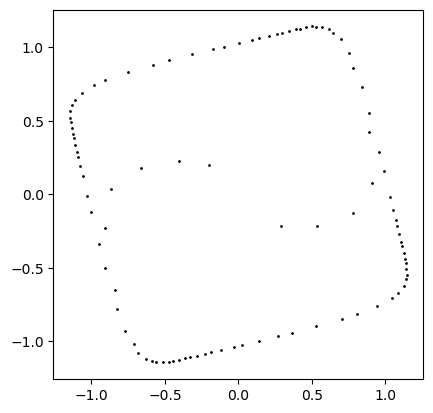

In [10]:
orbit = orbiter([-.2,.2])
plt.scatter(orbit[0,:],orbit[1,:],c='k',s=1)
plt.gca().set_aspect('equal')


In [32]:
%%manim -ql -v WARNING --disable_caching TwoNeuronRecurrentNetwork

class TwoNeuronRecurrentNetwork(Scene):
    def construct(self):
        viridis_cmap = matplotlib.colormaps['viridis']
        def point_to_color(x, y):
            normed_value = norm(x+y) # Use x-coordinate for color mapping
            color = viridis_cmap(normed_value)
            return list(color[:3])
        x_range = y_range= [-2, 2, 6]  # Start, end, and step size for x-axis
        #y_range = [-3, 3, 5]  # Start, end, and step size for y-axis
        axis_length = 7  # Length of each axis in the scene
        
        
        # Create axes with specified ranges and length

        axes = Axes(
            x_range=x_range,
            y_range=y_range,
            x_length=axis_length,
            y_length=axis_length,
            axis_config={"include_numbers": True}  # Display numbers on axes
        )

        #self.play(Create(axes))
        self.add(axes)
        # Step 1: Initialize a grid of dots
        grid_size = 20  # Define a 5x5 grid
        x_coords = y_coords = np.linspace(-2, 2, grid_size)
        normarray = x_coords+y_coords
        norm = matplotlib.colors.Normalize(vmin=normarray.min(), vmax=normarray.max())
        #y_coords = np.linspace(-2, 2, grid_size)
        dotrad = 0.05
        # dot = Dot(color=[point_to_color(0,6)])
        dots = VGroup(*[Dot(axes.c2p(*(x,y)),radius=dotrad,color=ManimColor.from_rgb(point_to_color(x, y))) for x in x_coords for y in y_coords])
        self.play(Create(dots))
        self.wait(0.5)

        # Step 2: Generate orbits for each dot using the `orbiter` function
        orbits = []
        for dot in dots:
            orbit = orbiter(dot.get_center()[:2]) # Replace with your actual `orbiter` function
            
            orbits.append(np.concatenate([orbit, np.zeros((1,orbit.shape[1] ))]))
        # Step 3: Animate the dots following their respective orbits
        num_steps = 30#orbits[0].shape[1]  # Ensure each dot has enough orbit steps
        for t in range(num_steps):
            #if t == 1: self.wait(3)
            for i, dot in enumerate(dots):
                
                dot.move_to(orbits[i][:,t])  # Move each dot to the next position in its orbit
            self.wait(0.2)  # Small pause to visualize each time step
    


Manim Community v0.18.1

In [13]:
# w11, w12 = -16, 4
w21 = -6
x0 = np.array([-1,1])

W = lambda p1,p2: np.array([[p1,p2],
                            [w21,0]])
b = lambda p1,p2: np.array([-3,4])

In [16]:
def orbiter(x0):
    
    #x0 = -np.array([0.1,0.1])
    w11, w12 = -18,8
    w21 = -6
    x0 = np.array([-1,1])

    W =  np.array([[w11,w12],
                    [w21,0]])
    b =  np.array([-3,4])
    orbit = neuron_2_discrete(x0,W,b,100,10).T
    return orbit

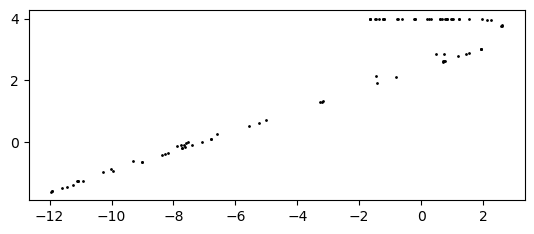

In [24]:
orbit = orbiter(2)
plt.scatter(orbit[0,:],orbit[1,:],c='k',s=1)
plt.gca().set_aspect('equal')